In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, False)

In [2]:
#Step 1: Load libraries for the U-net Model

import cv2
from focal_loss import SparseCategoricalFocalLoss
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow as tf

#### Data Import

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [4]:
import matplotlib.pyplot as plt 
from tensorflow.python.keras import losses

In [5]:
folder= "D:/nvgaze/train_images"
images = load_images_from_folder(folder)
image_array = np.array(images)

In [6]:
mask_array = np.load('D:/nvgaze/labels.npy')

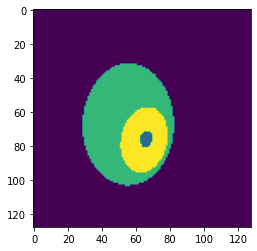

In [7]:
plt.imshow(mask_array[1058])

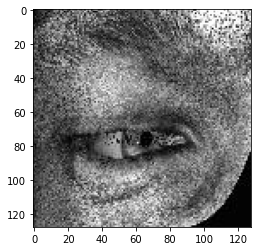

In [8]:
plt.imshow(image_array[1058])

In [9]:
mask_array.shape, image_array.shape

((11400, 128, 128), (11400, 128, 128, 3))

In [10]:
np.unique(mask_array[1058])

array([0, 1, 2, 3], dtype=uint8)

#### Encode labels... but multi dim array so need to flatten, encode and reshape

Not necessary in this case

In [11]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_array.shape
n,h,w

(11400, 128, 128)

In [12]:
train_masks_reshaped = mask_array.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
encoded_mask_array = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(encoded_mask_array)

C:\Users\anark\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3], dtype=int64)

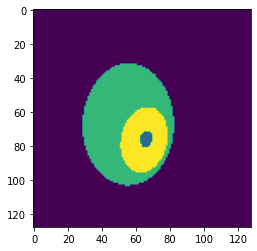

In [13]:
plt.imshow(mask_array[1058])

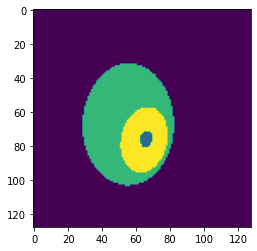

In [14]:
plt.imshow(encoded_mask_array[1058])

In [15]:
# Check for equality
problem = []
for i in range(0, encoded_mask_array.shape[0]):    
    if np.all(encoded_mask_array[i] == mask_array[i]) == False:
        problem = problem+ [i]
        
problem

[]

In [16]:
np.unique(mask_array)

array([0, 1, 2, 3], dtype=uint8)

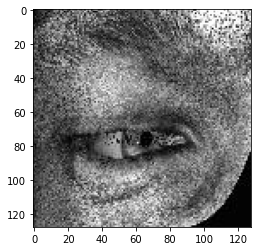

In [17]:
plt.imshow(image_array[1058])

In [18]:
from tensorflow.keras.utils import to_categorical

In [19]:
train_masks_cat = to_categorical(mask_array, num_classes=4)
y_train_cat = train_masks_cat.reshape((mask_array.shape[0], mask_array.shape[1], mask_array.shape[2], 4))

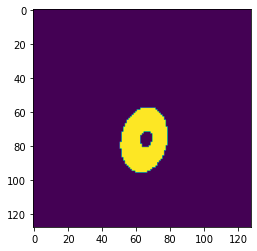

In [20]:
plt.imshow(y_train_cat[1058,:,:,3])

In [21]:
image_array.shape

(11400, 128, 128, 3)

In [22]:
train_images = image_array/255

In [23]:
np.max(train_images)

1.0

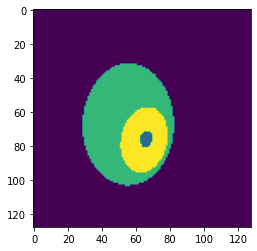

In [24]:
plt.imshow(mask_array[1058])

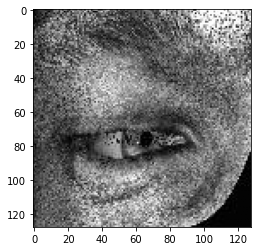

In [25]:
plt.imshow(train_images[1058])

In [26]:
train_images.shape

(11400, 128, 128, 3)

#### Multiclass Focal Loss

#### Training Model

In [27]:
def multi_unet_model(n_classes=4, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    
    
    return model

In [28]:
np.unique(train_masks_reshaped_encoded)

array([0, 1, 2, 3], dtype=int64)

In [29]:
# Split Dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, mask_array, test_size=0.15, random_state=1)

In [30]:
np.unique(train_masks_reshaped_encoded)

array([0, 1, 2, 3], dtype=int64)

In [31]:
from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_masks_reshaped_encoded),
#                                                  train_masks_reshaped_encoded)
# print("Class weights are...:", class_weights)
# # class_weights = {i : class_weights[i] for i in range(4)}

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [32]:
#Step 4: Define Dice Loss
# https://stackoverflow.com/questions/72195156/correct-implementation-of-dice-loss-in-tensorflow-keras
# https://notebook.community/cshallue/models/samples/outreach/blogs/segmentation_blogpost/image_segmentation
    
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def cce_dice_loss(y_true, y_pred):
    loss = losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [33]:
#NOTE: Compile the model in the main program to make it easy to test with various loss functions
model = multi_unet_model(n_classes=4, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'conv2d_1[0][0]']               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_8 (Dropout)            (None, 128, 128, 16  0           ['conv2d_16[0][0]']              
          

In [34]:
np.max(X_train),np.max(y_train)

(1.0, 3)

In [35]:
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

In [36]:
X_train.dtype

dtype('float32')

#### Callbacks

In [37]:
import datetime

In [38]:
save_model_path = 'D:/nvgaze/tmp/weights_vmulticlass_200.hdf5'
log_dir = "D:/nvgaze/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [39]:
def scheduler(epoch, lr):
    if epoch < 15:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [40]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    min_delta=0.001
    patience=20,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [41]:
def weighted_categorical_crossentropy():
    weights = [0.006457511670442963,
             0.8586677615343339,
             0.0380438832541546,
             0.09683084354106855]
    def wcce(y_true, y_pred):
        Kweights = keras.constant(weights)
        if not tf.keras.backend.is_keras_tensor(tf.keras.backend.variable(y_pred)):
            y_pred = tf.keras.backend.constant(y_pred)
        y_true = keras.cast(y_true, y_pred.dtype)
        return tf.keras.losses.categorical_crossentropy(y_true, y_pred) * keras.sum(y_true * Kweights, axis=-1)
    return wcce

In [42]:
loss = weighted_categorical_crossentropy()

In [43]:
from focal_loss import sparse_categorical_focal_loss

In [44]:
def multiclass_focal_loss():
    weights = [ 0.006457511670442963, 0.8586677615343339,
             0.0380438832541546, 0.09683084354106855]

    def spfl(y_true, y_pred,given_gamma=2):
        loss = sparse_categorical_focal_loss(y_true, y_pred,gamma=given_gamma, class_weight=weights)
        spcce = losses.sparse_categorical_crossentropy(y_true, y_pred)
        return loss + spcce

    
    
    return spfl

In [45]:
mfl = multiclass_focal_loss()

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=mfl,
              metrics=['accuracy'])

In [47]:
# import tensorflow.keras.backend as K

In [48]:
np.max(y_train)

3.0

In [49]:
#Step 4: Fit the u-net model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('C:/Users/anark/Downloads/nvgaze/models/unet_MC_v2_wcce_200.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X_train,y_train,epochs=200,batch_size=16,
          validation_data=(X_val, y_val),
          callbacks=[tensorboard_callback,model_checkpoint,scheduler_callback,early_stop]
          )


Epoch 1/200
606/606 [==============================] - ETA: 0s - loss: 0.6011 - accuracy: 0.8024
Epoch 1: loss improved from inf to 0.60106, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 17s 18ms/step - loss: 0.6011 - accuracy: 0.8024 - val_loss: 0.4294 - val_accuracy: 0.8096 - lr: 0.0100
Epoch 2/200
606/606 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8139
Epoch 2: loss improved from 0.60106 to 0.44413, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 10s 17ms/step - loss: 0.4441 - accuracy: 0.8139 - val_loss: 0.4384 - val_accuracy: 0.8197 - lr: 0.0100
Epoch 3/200
604/606 [============================>.] - ETA: 0s - loss: 0.3846 - accuracy: 0.8327
Epoch 3: loss improved from 0.44413 to 0.38462, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [============================

604/606 [============================>.] - ETA: 0s - loss: 0.0593 - accuracy: 0.9777
Epoch 23: loss improved from 0.06046 to 0.05933, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 11s 19ms/step - loss: 0.0593 - accuracy: 0.9777 - val_loss: 0.0590 - val_accuracy: 0.9779 - lr: 0.0045
Epoch 24/200
606/606 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9787
Epoch 24: loss improved from 0.05933 to 0.05658, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 12s 19ms/step - loss: 0.0566 - accuracy: 0.9787 - val_loss: 0.0473 - val_accuracy: 0.9821 - lr: 0.0041
Epoch 25/200
605/606 [============================>.] - ETA: 0s - loss: 0.0534 - accuracy: 0.9797
Epoch 25: loss improved from 0.05658 to 0.05343, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================]

605/606 [============================>.] - ETA: 0s - loss: 0.0396 - accuracy: 0.9844
Epoch 45: loss improved from 0.03969 to 0.03955, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 11s 17ms/step - loss: 0.0395 - accuracy: 0.9844 - val_loss: 0.0350 - val_accuracy: 0.9866 - lr: 4.9787e-04
Epoch 46/200
606/606 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9846
Epoch 46: loss improved from 0.03955 to 0.03920, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 11s 17ms/step - loss: 0.0392 - accuracy: 0.9846 - val_loss: 0.0346 - val_accuracy: 0.9866 - lr: 4.5049e-04
Epoch 47/200
603/606 [============================>.] - ETA: 0s - loss: 0.0391 - accuracy: 0.9846
Epoch 47: loss improved from 0.03920 to 0.03912, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [=======================

Epoch 67/200
606/606 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9853
Epoch 67: loss did not improve from 0.03713
606/606 [==============================] - 10s 17ms/step - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.0332 - val_accuracy: 0.9872 - lr: 5.5166e-05
Epoch 68/200
606/606 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9853
Epoch 68: loss improved from 0.03713 to 0.03707, saving model to C:/Users/anark/Downloads/nvgaze/models\unet_MC_v2_wcce_200.hdf5
606/606 [==============================] - 10s 16ms/step - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.0334 - val_accuracy: 0.9872 - lr: 4.9916e-05
Epoch 69/200
604/606 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9853
Epoch 69: loss did not improve from 0.03707
606/606 [==============================] - 10s 17ms/step - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.0333 - val_accuracy: 0.9873 - lr: 4.5166e-05
Epoch 70/200
606/606 [=================

Epoch 94/200
603/606 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9854
Epoch 94: loss did not improve from 0.03678
606/606 [==============================] - 10s 17ms/step - loss: 0.0368 - accuracy: 0.9854 - val_loss: 0.0331 - val_accuracy: 0.9873 - lr: 3.7074e-06
Epoch 95/200
606/606 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9854
Epoch 95: loss did not improve from 0.03678
606/606 [==============================] - 10s 17ms/step - loss: 0.0369 - accuracy: 0.9854 - val_loss: 0.0332 - val_accuracy: 0.9873 - lr: 3.3546e-06
Epoch 96/200
604/606 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9853
Epoch 96: loss did not improve from 0.03678
606/606 [==============================] - 10s 17ms/step - loss: 0.0369 - accuracy: 0.9853 - val_loss: 0.0331 - val_accuracy: 0.9873 - lr: 3.0354e-06
Epoch 97/200
603/606 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9854
Epoch 97: loss did not imp

606/606 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9854
Epoch 121: loss did not improve from 0.03672
606/606 [==============================] - 10s 17ms/step - loss: 0.0369 - accuracy: 0.9854 - val_loss: 0.0331 - val_accuracy: 0.9873 - lr: 2.4916e-07
Epoch 122/200
605/606 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9854
Epoch 122: loss did not improve from 0.03672
606/606 [==============================] - 10s 17ms/step - loss: 0.0368 - accuracy: 0.9854 - val_loss: 0.0331 - val_accuracy: 0.9873 - lr: 2.2545e-07
Epoch 123/200
605/606 [============================>.] - ETA: 0s - loss: 0.0369 - accuracy: 0.9854
Epoch 123: loss did not improve from 0.03672
606/606 [==============================] - 10s 17ms/step - loss: 0.0368 - accuracy: 0.9854 - val_loss: 0.0331 - val_accuracy: 0.9873 - lr: 2.0399e-07
Epoch 124/200
605/606 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9854
Epoch 124: loss improved from 0.0

1/1 [==============================] - 1s 556ms/step


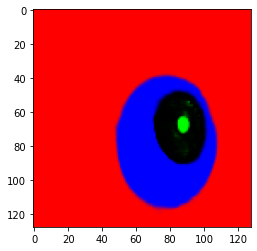

In [50]:
plt.imshow(model.predict(X_train[75:76])[0,:,:,0:3])

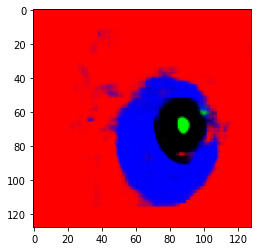

In [83]:
plt.imshow(model.predict(X_train[75:76])[0,:,:,0:3])

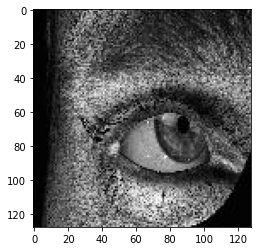

In [52]:
plt.imshow(X_train[75])

In [53]:
folder= "D:/nvgaze/test_images"
images = load_images_from_folder(folder)
image_array = np.array(images)

In [56]:
img = image_array/255


In [54]:
folder= "D:/nvgaze/test_masks"
masks = load_images_from_folder(folder)
masks_array = np.array(masks)[:,:,:,0]

1/1 [==============================] - 0s 13ms/step


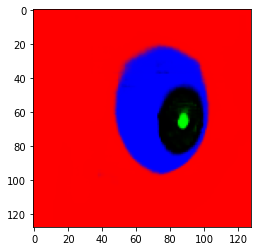

In [62]:
plt.imshow(model.predict(img[10:11])[0,:,:,0:3])

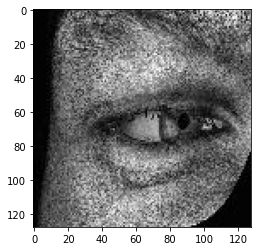

In [63]:
plt.imshow(img[10])

#### EXTRA

1. Annotating Data in 4 levels
Based on visual examination, there were 4 distinct colors that could be identified. Basd on RGB values of these colors, I divided colors in the numpy array into these catergories based on how closely they resemble these colors

Reference
[1] https://stackoverflow.com/questions/57496971/map-colors-in-image-to-closest-member-of-a-list-of-colors-in-python

In [14]:
from scipy.spatial import cKDTree
colors = np.array([[0, 0, 0], [0, 255, 0], 
                   [255,255,0],[255,220,0]])

for i in range(0,mask_array.shape[0]):
    mask_array[i] = colors[cKDTree(colors).query(mask_array[i],k=1)[1]]

array([[  0,   0,   0],
       [  0, 255,   0],
       [255, 220,   0],
       [255, 255,   0]], dtype=uint8)

In [16]:
label_masks = np.zeros_like(mask_array)
label_masks = label_masks[:,:,:,0]
label_masks.shape

(11400, 128, 128)

In [17]:
np.all(mask_array[1,2,3] == [0,0.2,0])

False

In [18]:
for i in range(0,label_masks.shape[0]):
    for j in range(0,label_masks.shape[1]):
        for k in range(0,label_masks.shape[2]):
            if np.all(mask_array[i,j,k] == [0,0,0]):
                label_masks[i,j,k] = 0
            elif np.all(mask_array[i,j,k] == [0,255,0]):
                label_masks[i,j,k] = 1
            elif np.all(mask_array[i,j,k] == [255,220,0]):
                label_masks[i,j,k] = 2
            else:
                label_masks[i,j,k] = 3
            
            

In [26]:
problem = []
for i in range(0,label_masks.shape[0]):
    if len(np.unique(label_masks[i]))!= 4:
        problem = problem + [i]

In [49]:
np.save('C:/Users/anark/Downloads/nvgaze/labels',label_masks)

In [52]:
np.unique(a)

array([0, 1, 2, 3], dtype=uint8)

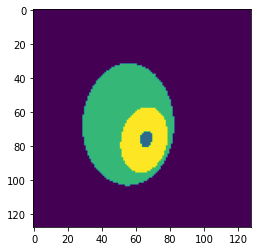

In [29]:

plt.imshow(label_masks[1058])

In [35]:
for i in range(0,label_masks.shape[0]):
    path_img = 'C:/Users/anark/Downloads/nvgaze/train_labels/img_' + str(i) + '.png'
    plt.imsave(path_img,label_masks[i])

In [43]:
label_masks.shape

(11400, 128, 128)

In [37]:
folder= "C:/Users/anark/Downloads/nvgaze/train_labels"
labels_img = load_images_from_folder(folder)
labels_img = np.array(labels_img)

In [42]:
labels_img[0,:,:,0]

array([[84, 84, 84, ..., 84, 84, 84],
       [84, 84, 84, ..., 84, 84, 84],
       [84, 84, 84, ..., 84, 84, 84],
       ...,
       [84, 84, 84, ..., 84, 84, 84],
       [84, 84, 84, ..., 84, 84, 84],
       [84, 84, 84, ..., 84, 84, 84]], dtype=uint8)

In [45]:
np.save()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [96]:
sample = mask_array[0].copy()
sample_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)

# for i in range(0,128):
#     for j in range(0,128):
#         if sample[i,j,1] in range(240 and sample[i,j,0] == 0:
#             sample[i,j,0] = 255
#             sample[i,j,2] = 255

In [86]:
for i in range(0,128):
    for j in range(0,128):
        if sample_gray[i,j] <= 0.25:
            sample_gray[i,j] = 0.25
        elif sample_gray[i,j] <= 0.50 and sample_gray[i,j] > 0.25:
            sample_gray[i,j] = 0.50
        elif sample_gray[i,j] <= 0.75 and sample_gray[i,j] > 0.75:
            sample_gray[i,j] = 0.75
        else:
            sample_gray[i,j] = 1.
            

In [131]:
counter = np.unique(out_img.reshape(-1, sample.shape[2]), axis=0)
counter

array([[  0,   0,   0],
       [  0, 255,   0],
       [255, 220,   0],
       [255, 255,   0]])

In [104]:
sample_no= sample/255
np.max(sample_no)

1.0

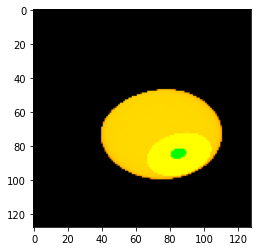

In [117]:
plt.imshow(sample_no)

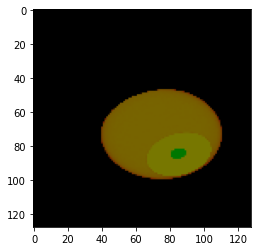

In [114]:
plt.imshow(p1)

In [119]:
p2 = sample_no[cKDTree(sample_no).query(img,k=1)[1]]

ValueError: data must be 2 dimensions

In [126]:
colors = np.array([[0, 0, 0], 
[0, 255, 0], 
[255,255,0],
[255,220,0]
])


In [127]:
out_img = colors[cKDTree(colors).query(img,k=1)[1]]

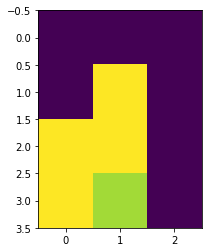

In [128]:
plt.imshow(colors)

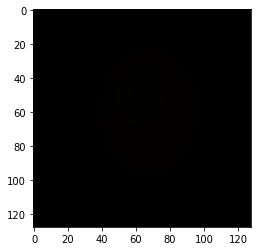

In [155]:
plt.imshow(p1/255)

In [130]:
np.unique(out_img)

array([  0, 220, 255])

In [148]:
#Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = out_img_normalized.shape
n,h,w

(128, 128, 3)

In [149]:
train_masks_reshaped_3 = out_img_normalized.reshape(-1,1)
train_masks_reshaped_encoded_3 = labelencoder.fit_transform(train_masks_reshaped_3)
p1 = train_masks_reshaped_encoded_3.reshape(n, h, w)

np.unique(p1)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([0, 1, 2], dtype=int64)

In [151]:
p1.shape

(128, 128, 3)

In [44]:
# counting unique colors in numpy array
np.unique(mask_array[0].reshape(-1, mask_array[0].shape[-1]), axis=0, return_counts=True)

(array([[  0,   0,   0],
        [  0, 255,   0],
        [ 45,  18,   0],
        [ 47,  19,   0],
        [ 49,  20,   0],
        [ 54, 255,   0],
        [ 65,  29,   0],
        [ 66,  29,   0],
        [ 77, 255,   0],
        [ 80,  36,   0],
        [ 80,  37,   0],
        [ 82,  37,   0],
        [ 84, 255,   0],
        [ 92,  43,   0],
        [ 94, 255,   0],
        [109,  52,   0],
        [121,  59,   0],
        [131, 255,   0],
        [148,  73,   0],
        [155,  77,   0],
        [157,  78,   0],
        [160,  79,   0],
        [160,  80,   0],
        [161,  80,   0],
        [186,  94,   0],
        [199, 100,   0],
        [220, 112,   0],
        [221, 112,   0],
        [231, 118,   0],
        [241, 123,   0],
        [242, 123,   0],
        [253, 129,   0],
        [255, 141,   0],
        [255, 144,   0],
        [255, 145,   0],
        [255, 147,   0],
        [255, 148,   0],
        [255, 149,   0],
        [255, 150,   0],
        [255, 152,   0],


In [47]:
#NOTE: Compile the model in the main program to make it easy to test with various loss functions
model = multi_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [47]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU
